In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random

import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg

In [2]:

# --- Configuration ---
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED) # if using GPU
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True # Ensure reproducibility
torch.backends.cudnn.benchmark = False

# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 50
NOISE_DIM = 100
LEARNING_RATE = 1e-4
IMAGE_SIZE = 28
NUM_CHANNELS = 1



Using device: cuda


### a. Fashion MNIST Dataset

- Images are 28x28 pixels, grayscale

In [3]:
# Directory to save generated images
output_dir = './dcgan_fashion_mnist_pytorch_outputs'
os.makedirs(output_dir, exist_ok=True)

# --- Data Loading and Preprocessing ---
print("Loading and preprocessing FashionMNIST data...")
# Normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] range
    transforms.Normalize((0.5,), (0.5,)) # Maps [0, 1] to [-1, 1]
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

print(f"Data loaded. Training dataset size: {len(train_dataset)}")
print(f"Using batch size: {BATCH_SIZE}")



Loading and preprocessing FashionMNIST data...


100%|██████████| 26.4M/26.4M [00:02<00:00, 9.72MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.4MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Data loaded. Training dataset size: 60000
Using batch size: 64


### b. Discriminator 
- Architecture (kernel size = 5 × 5 with stride = 2 in both directions):
- 2D convolutions (1 × 28 × 28 → 64 × 14 × 14 → 128 × 7 × 7)
- Each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed by Dropout with parameter 0.3.
- A dense layer that takes the flattened output of the last convolution and maps it to a scalar.

In [ ]:
# --- Discriminator Model (Part b) ---
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 1x28x28
            # Conv 1: 1x28x28 -> 64x14x14
            nn.Conv2d(NUM_CHANNELS, 64, kernel_size=5, stride=2, padding=2), # Output size formula: floor((H_in + 2*padding - kernel_size)/stride) + 1
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),

            # Conv 2: 64x14x14 -> 128x7x7
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.3),

            # Flatten and Dense
            nn.Flatten(), # 128 * 7 * 7 = 6272
            nn.Linear(128 * 7 * 7, 1) # Output is a scalar logit
        )

    def forward(self, x):
        return self.model(x)




### c. Generator

- Architecture (kernel size = 5 × 5, stride = 2, padding = 2)
- Dense layer that takes a unit Gaussian noise vector of length 100 and maps it to a vector of size
7 ∗ 7 ∗ 256. No bias terms.
- Each layer has transpose 2D convolutions (256 × 7 × 7 → 128 × 7 × 7 → 64 × 14 × 14 → 1 × 28 × 28). No
bias terms.
- Each convolutional layer (except the last one) is equipped with Batch Normalization (batch norm),
followed by Leaky ReLU with slope 0.3. 
- The last (output) layer is equipped with tanh activation (no batch norm).

In [ ]:
# --- Generator Model (Part c) ---
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super().__init__()
        self.noise_dim = noise_dim

        self.main = nn.Sequential(
            # Start from noise vector: noise_dim -> 7*7*256
            nn.Linear(noise_dim, 7 * 7 * 256, bias=False),
            nn.BatchNorm1d(7 * 7 * 256),
            nn.LeakyReLU(0.3),

            # Reshape to spatial volume: 256x7x7
            nn.Unflatten(1, (256, 7, 7)), # Unflatten after the linear layer

            # Transpose Conv 1: 256x7x7 -> 128x7x7 (stride 1)
            # Output size formula: (H_in - 1)*stride - 2*padding + kernel_size + output_padding
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, output_padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.3),

            # Transpose Conv 2: 128x7x7 -> 64x14x14 (stride 2)
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.3),

            # Transpose Conv 3: 64x14x14 -> 1x28x28 (stride 2)
            nn.ConvTranspose2d(64, NUM_CHANNELS, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh() # Output activation
        )

    def forward(self, x):
        return self.main(x)



In [5]:
generator = Generator(NOISE_DIM).to(device)
print(generator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.3)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.3)
    (7): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.3)
    (10): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (11): Tanh()
  )
)


In [6]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.3)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
  )
)


In [7]:
# --- Loss Function and Optimizers (Part d) ---
# BCELoss with logits is numerically more stable than using Sigmoid + BCELoss
criterion = nn.BCEWithLogitsLoss()

optimizer_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
optimizer_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE)



In [8]:
# --- Training Setup ---
# Fixed noise vector to visualize generation progress
num_examples_to_generate = 16 # 4x4 grid
fixed_noise = torch.randn(num_examples_to_generate, NOISE_DIM, device=device)

# Function to generate and save images
def generate_and_save_images(model, epoch, test_input):
    model.eval() # Set generator to evaluation mode
    with torch.no_grad(): # No gradients needed for inference
        predictions = model(test_input)

    # Rescale images from [-1, 1] to [0, 1]
    predictions = (predictions * 0.5) + 0.5
    predictions = torch.clamp(predictions, 0, 1) # Clamp to be safe

    # Save the grid of images
    save_image(predictions, os.path.join(output_dir, f'image_at_epoch_{epoch:03d}.png'), nrow=int(np.sqrt(num_examples_to_generate)))

    model.train() # Set generator back to training mode

### d. Training
- The generator and discriminator are trained each epoch.
- The generator is trained to minimize the binary cross-entropy loss between the discriminator's output
and the target label of 1 (real).
- The discriminator is trained to minimize the binary cross-entropy loss between the discriminator's output
and the target label of 0 (fake) for the generated images and 1 (real) for the real images.
- The training is done for 50 epochs with a batch size of 64.
- Each 10th epoch, the output of the generator is saved to a png file.

In [9]:
# --- Training Loop (Part e) ---
avg_g_losses = []
avg_d_losses = []

print(f"Starting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    start_time = time.time()
    total_d_loss = 0
    total_g_loss = 0
    num_batches = 0

    for i, data in enumerate(train_loader):
        real_images, _ = data
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # --- Train Discriminator ---
        discriminator.zero_grad()

        # Train with real images
        label_real = torch.full((batch_size,), 1.0, device=device) # Labels for real images are 1
        output_real = discriminator(real_images).view(-1)
        loss_d_real = criterion(output_real, label_real)

        # Train with fake images
        noise = torch.randn(batch_size, NOISE_DIM, device=device)
        fake_images = generator(noise)
        label_fake = torch.full((batch_size,), 0.0, device=device) # Labels for fake images are 0
        # Detach fake images from generator's graph so gradients don't flow back to generator during D training
        output_fake = discriminator(fake_images.detach()).view(-1)
        loss_d_fake = criterion(output_fake, label_fake)

        # Total discriminator loss
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward() # Compute gradients
        optimizer_d.step() # Update discriminator weights

        total_d_loss += loss_d.item()

        # --- Train Generator ---
        generator.zero_grad()

        # Generate fake images again (or use the previous ones, but re-calculate discriminator output)
        # We want the discriminator to classify fake images as real (label 1)
        noise = torch.randn(batch_size, NOISE_DIM, device=device)
        fake_images = generator(noise)
        label_generator = torch.full((batch_size,), 1.0, device=device) # Generator's target labels are 1 (fooling D)
        output_generator = discriminator(fake_images).view(-1) # Discriminator's output on fake images

        # Generator loss
        loss_g = criterion(output_generator, label_generator)
        loss_g.backward() # Compute gradients
        optimizer_g.step() # Update generator weights

        total_g_loss += loss_g.item()
        num_batches += 1

    avg_d_loss = total_d_loss / num_batches
    avg_d_losses.append(avg_d_loss)
    avg_g_loss = total_g_loss / num_batches
    avg_g_losses.append(avg_g_loss)

    epoch_time = time.time() - start_time


    # Generate and save images at specified epochs
    if (epoch + 1) % 10 == 0:
        generate_and_save_images(generator, epoch + 1, fixed_noise)
        print(f'Epoch {epoch+1}/{EPOCHS} | Gen Loss: {avg_g_loss:.4f} | Disc Loss: {avg_d_loss:.4f} | Time: {epoch_time:.2f} sec')

print("\nTraining finished.")
print(f"Generated images saved in '{output_dir}'.")

Starting training for 50 epochs...
Epoch 10/50 | Gen Loss: 1.7284 | Disc Loss: 0.8499 | Time: 12.10 sec
Epoch 20/50 | Gen Loss: 1.3498 | Disc Loss: 1.0136 | Time: 12.23 sec
Epoch 30/50 | Gen Loss: 1.2138 | Disc Loss: 1.0924 | Time: 12.36 sec
Epoch 40/50 | Gen Loss: 1.0798 | Disc Loss: 1.1707 | Time: 12.31 sec
Epoch 50/50 | Gen Loss: 1.0007 | Disc Loss: 1.2209 | Time: 12.29 sec

Training finished.
Generated images saved in './dcgan_fashion_mnist_pytorch_outputs'.


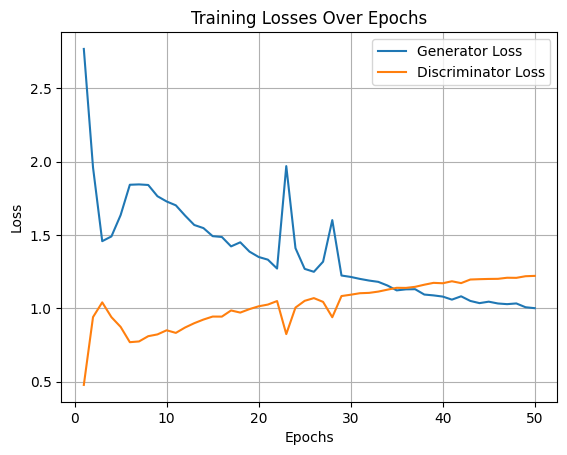

In [10]:
epochs = range(1, len(avg_g_losses) + 1)

plt.figure()
plt.plot(epochs, avg_g_losses, label='Generator Loss')
plt.plot(epochs, avg_d_losses, label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

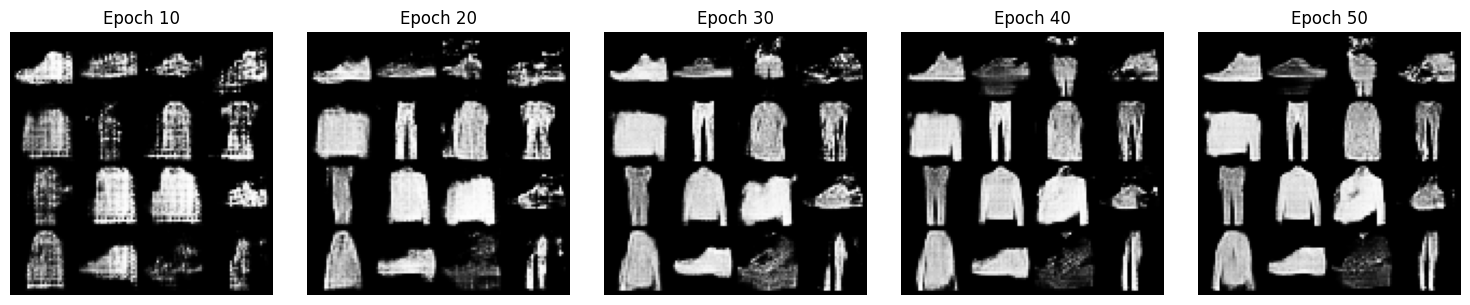

In [11]:
# Directory containing the images

output_dir = 'dcgan_fashion_mnist_pytorch_outputs'  # Replace with your actual path

# Epochs to show
epochs = [10, 20, 30, 40, 50]

# Create a 1x5 subplot
fig, axes = plt.subplots(1, len(epochs), figsize=(15, 3))

for i, epoch in enumerate(epochs):
    img_path = os.path.join(output_dir, f'image_at_epoch_{epoch:03d}.png')
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Epoch {epoch}")
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()